In [28]:
!pip install ibm_watsonx_ai langchain_ibm langgraph pypdf

In [29]:
import json
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain_ibm import WatsonxEmbeddings, WatsonxLLM, ChatWatsonx
from datetime import datetime, timedelta
from typing import List, Dict, TypedDict, Literal
from pydantic import BaseModel
import pandas as pd
import plotly.express as px
from langgraph.graph import StateGraph, END, START
from typing import Optional
from pathlib import Path
from typing import Optional
from pydantic import field_validator
from langchain_core.runnables import RunnablePassthrough
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
import os
from langchain.schema import HumanMessage, SystemMessage
import re
from datetime import timedelta
from pypdf import PdfReader

In [ ]:
watsonx_api_key = "YOUR_API_KEY"
project_id = "YOUR_PROJECT_ID"
url = "https://us-south.ml.cloud.ibm.com"
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 1000,
    GenParams.TEMPERATURE: 0.2,
}
llm = WatsonxLLM(
    model_id="ibm/granite-3-2b-instruct",
    url=url,
    apikey=watsonx_api_key,
    project_id=project_id,
    params=parameters
)

In [36]:
class ProjectCharter(BaseModel):
    project_name: str
    description: str
    start_date: datetime
    end_date: datetime
    stakeholders: List[str]
    objectives: List[str]

class Task(BaseModel):
    task_id: str
    task_name: str
    duration_days: int
    dependencies: List[str]
    responsible_team: str
    category: str

class Resource(BaseModel):
    resource_id: str
    resource_name: str
    type: str
    team_size: int
    availability: dict
    cost_per_day_per_person: int
    allocated_tasks: List[str]

class Risk(BaseModel):
    risk_id: str
    risk_name: str
    category: str
    probability: str
    impact: str
    potential_effect: str
    mitigation_strategy: str
    monitoring_plan: str

class ProgressReport(BaseModel):
    task_id: str
    completion_percentage: float
    delays: int

class TaskProgress(BaseModel):
    task_id: str
    task_name: str
    planned_start_date: datetime
    planned_end_date: datetime
    actual_start_date: Optional[datetime] = None
    actual_end_date: Optional[datetime] = None
    progress_percentage: float
    status: str
    issues: str

    @field_validator("actual_start_date", "actual_end_date", mode="before")
    @classmethod
    def validate_optional_datetime(cls, value):
        if value in (None, "", " "):
            return None
        return datetime.strptime(value, "%Y-%m-%d")

class IssuesAndDelays(BaseModel):
    issue_id: int
    description: str
    resolution_status: str


# AgentState Definition

class AgentState(TypedDict):
    charter: List[ProjectCharter]
    tasks: List[Dict]
    resources: List[Dict]
    risks: List[Risk]
    project_schedule: Dict
    progress_reports: List[TaskProgress]
    task_progress: List[TaskProgress]
    issues_and_delays: List[IssuesAndDelays]
    max_iteration: int
    iteration_number: int
    project_risk_score_iterations: List[int]
    data_loaded: bool
    data_changed: bool
    next_step: Optional[str]
    is_first_run: bool
    has_changes: bool
    proceed: Optional[bool]


# Node Functions

def project_supervisor_node(state: AgentState) -> AgentState:
    print("Project Supervisor Node executed.")
    return state

def change_manager_node(state: AgentState) -> AgentState:
    print("Change Manager Node executed.")
    if state["is_first_run"] and not state["has_changes"]:
        state["next_step"] = "cde_agent"
    elif not state["is_first_run"] and not state["has_changes"]:
        state["next_step"] = "human_reporting"
    elif not state["is_first_run"] and state["has_changes"]:
        state["next_step"] = "project_expert"
    else:
        state["next_step"] = None
    return state

def ingest_charter_node(state: AgentState) -> AgentState:
    base_path = Path("data")
    try:
        with open(base_path / "charter.json", "r") as file:
            charter_data = json.load(file)


        if isinstance(charter_data, list):
            charter_data = charter_data[0]

        charter_obj = ProjectCharter(**charter_data)
        state["charter"] = [charter_obj]
        print("CDE Agent: Charter data ingested.")
    except Exception as e:
        print(f"CDE Agent Error (charter): {e}")
    return state

def ingest_tasks_node(state: AgentState) -> AgentState:
    base_path = Path("data")
    try:
        with open(base_path / "tasks.json", "r") as file:
            tasks = json.load(file)
        state["tasks"] = tasks
        print("CDE Agent: Tasks data ingested.")
    except Exception as e:
        print(f"CDE Agent Error (tasks): {e}")
    return state

def ingest_resources_node(state: AgentState) -> AgentState:
    base_path = Path("data")
    try:
        with open(base_path / "resources.json", "r") as file:
            resources = json.load(file)
        state["resources"] = resources
        print("CDE Agent: Resources data ingested.")
    except Exception as e:
        print(f"CDE Agent Error (resources): {e}")
    return state
def ingest_risks_node(state: AgentState) -> AgentState:
    base_path = Path("data")
    try:
        with open(base_path / "risks.json", "r") as file:
            risks_data = json.load(file)


        if isinstance(risks_data, list):
            risks_list = risks_data
        else:
            risks_list = risks_data.get("risks", [])

        risks = [Risk(**item) for item in risks_list]
        state["risks"] = risks
        print("CDE Agent: Risks data ingested.")
    except Exception as e:
        print(f"CDE Agent Error (risks): {e}")
    return state


def ingest_progress_node(state: AgentState) -> AgentState:
    base_path = Path("data")
    try:
        with open(base_path / "progress_updates.json", "r") as file:
            progress_data = json.load(file)


        if isinstance(progress_data, list):
            progress_list = progress_data
        else:
            progress_list = progress_data.get("progress_updates", [])

        progress_reports = [TaskProgress(**task) for task in progress_list]
        state["progress_reports"] = progress_reports
        print("CDE Agent: Progress updates ingested.")
    except Exception as e:
        print(f"CDE Agent Error (progress): {e}")
    return state

def cde_agent_node(state: AgentState) -> AgentState:
    print("CDE Agent: Initiating data ingestion.")
    state["data_changed"] = False
    state = ingest_charter_node(state)
    state = ingest_tasks_node(state)
    state = ingest_resources_node(state)
    state = ingest_risks_node(state)
    state = ingest_progress_node(state)
    state["is_first_run"] = False
    state["next_step"] = "project_status"
    return state





def human_reporting_node(state: AgentState) -> AgentState:
    print("Human Reporting: Please enter issues and delays.")

# Loop to collect multiple issues
    issue = input("Enter issue description (or type 'done' to finish): ").strip()
    if issue.lower() == 'done':
        print("exit")
    if issue:
        issue_entry = {
            "issue_id": len(state["issues_and_delays"]) + 1,
            "description": issue,
            "resolution_status": "Pending"
        }
        state["issues_and_delays"].append(issue_entry)
        print(f"Issue added: {issue_entry}")


    decision = input("Continue workflow? (y/n): ").strip().lower()
    if decision == 'n':
        state["next_step"] = END
    else:
        state["has_changes"] = True
        state["next_step"] = "change_manager"
    return state

PDF_FILE_PATH = "Risk_mitigation.pdf"



def extract_text_from_pdf(pdf_path: str) -> str:
    """Reads and extracts text content from a PDF file using pypdf."""
    try:
        reader = PdfReader(pdf_path)
        text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
        return text
    except Exception as e:
        print(f"Error reading PDF file: {e}")
        return ""

def get_pdf_content_for_task(task_id: str) -> str:
    """Extracts relevant content from the compliance PDF for a given task."""
    pdf_text = extract_text_from_pdf(PDF_FILE_PATH)
    if not pdf_text:
        return f"Error: Unable to extract content for task {task_id}."

    pattern = rf"{task_id}[\s\S]*?(?=\nT\d+|\Z)"
    match = re.search(pattern, pdf_text)
    return match.group(0) if match else f"No compliance PDF content found for task {task_id}."

def extract_info_with_regex(issue_description: str) -> (str, int):
    """Extracts the task ID and delay duration from an issue description using regex."""
    task_match = re.search(r'\b(T\d+)\b', issue_description)
    task_id = task_match.group(1) if task_match else None

    delay_match = re.search(r'delay\s*[:]?\s*(\d+)', issue_description, re.IGNORECASE)
    delay_days = int(delay_match.group(1)) if delay_match else 15

    return task_id, delay_days

def get_mitigation_response(task_id: str, issue_description: str) -> str:
    """Uses WatsonxLLM to generate a detailed, structured mitigation response."""
    pdf_content = get_pdf_content_for_task(task_id)

    prompt = (
        f"### Project Task Mitigation Plan\n\n"
        f"**Task Delayed:** {task_id}\n"
        f"**Issue Identified:** {issue_description}\n\n"
        f"**Project Schedule & Dependencies:**\n"
        f"{pdf_content}\n\n"
        "**Your Role:**\n"
        "You are a senior project manager responsible for optimizing task execution. "
        "Analyze the task dependencies and resource allocation from the provided project schedule. \n\n"
        "**Your Response Should Include:**\n"
        "1. **Alternative Task Execution:** If {task_id} is delayed, what other tasks can be executed in parallel using the same resources?\n"
        "2. **Dependency Analysis:** Are there tasks that depend on {task_id}? If so, how can we minimize their delay?\n"
        "3. **Resource Reallocation Strategy:** Can the allocated resources be reassigned to another pending task to optimize efficiency?\n"
        "4. **Next Steps:** Provide a concrete action plan to keep the project moving while resolving the issue.\n\n"
        "Use specific examples from the provided project schedule and avoid generic recommendations."
    )

    try:
        response = llm(prompt)
        return response
    except Exception as e:
        print(f"Mitigation LLM call failed with error: {e}.")
        return "Mitigation response not available due to an error."


def project_expert_node(state: dict) -> dict:

    print("Project Expert Node executed.")
    if "project_schedule" not in state or not state["project_schedule"]:
        print("Project Expert: No project schedule available to update.")
        return state

    schedule = state["project_schedule"]

    for issue in state.get("issues_and_delays", []):
        issue_description = issue.get("description", "")
        task_id, delay_days = extract_info_with_regex(issue_description)

        if not task_id:
            print(f"Project Expert: No task ID found in issue '{issue_description}'.")
            continue

        if delay_days <= 0:
            print(f"Project Expert: No delay adjustment needed for issue '{issue_description}'.")
            continue

        print(f"Project Expert: Detected delay of {delay_days} days for task {task_id} due to issue '{issue_description}'.")

        if task_id not in schedule:
            print(f"Project Expert: Task {task_id} not found in the schedule.")
            continue


        original_start = schedule[task_id]["start_date"]
        original_end = schedule[task_id]["end_date"]
        new_start = original_start + timedelta(days=delay_days)
        new_end = original_end + timedelta(days=delay_days)
        schedule[task_id]["start_date"] = new_start
        schedule[task_id]["end_date"] = new_end
        print(f"Project Expert: Updated task {task_id} start date from {original_start} to {new_start} and end date from {original_end} to {new_end}.")


        for task in state.get("tasks", []):
            if task_id in task.get("dependencies", []):
                dep_task_id = task["task_id"]
                dep_new_start = new_end
                duration = task["duration_days"]
                new_dep_end = dep_new_start + timedelta(days=duration)
                if dep_task_id in schedule:
                    old_dep_start = schedule[dep_task_id]["start_date"]
                    old_dep_end = schedule[dep_task_id]["end_date"]
                    schedule[dep_task_id]["start_date"] = dep_new_start
                    schedule[dep_task_id]["end_date"] = new_dep_end
                    print(f"Project Expert: Updated dependent task {dep_task_id} from start {old_dep_start}, end {old_dep_end} to new start {dep_new_start}, new end {new_dep_end}.")
                else:
                    schedule[dep_task_id] = {
                        "start_date": dep_new_start,
                        "end_date": new_dep_end,
                        "task_name": task["task_name"]
                    }
                    print(f"Project Expert: Added schedule for dependent task {dep_task_id} with start {dep_new_start} and end {new_dep_end}.")


        affected_dependencies = None
        for task in state.get("tasks", []):
            if task["task_id"] == task_id:
                affected_dependencies = task.get("dependencies", [])
                break
        if affected_dependencies:
            dep_end_dates = []
            for dep in affected_dependencies:
                if dep in schedule:
                    dep_end_dates.append(schedule[dep]["end_date"])
            if dep_end_dates:
                ideal_start = max(dep_end_dates)

                for task in state.get("tasks", []):
                    sibling_id = task["task_id"]
                    if sibling_id == task_id:
                        continue
                    if task.get("dependencies", []) == affected_dependencies:
                        if sibling_id in schedule:
                            old_sibling_start = schedule[sibling_id]["start_date"]
                            duration = task["duration_days"]
                            if old_sibling_start > ideal_start:
                                new_sibling_start = ideal_start
                                new_sibling_end = new_sibling_start + timedelta(days=duration)
                                schedule[sibling_id]["start_date"] = new_sibling_start
                                schedule[sibling_id]["end_date"] = new_sibling_end
                                print(f"Project Expert: Adjusted sibling task {sibling_id} to start at {new_sibling_start} and end at {new_sibling_end}.")

                                if schedule[task_id]["start_date"] < new_sibling_end:
                                    affected_duration = original_end - original_start
                                    updated_affected_start = new_sibling_end
                                    updated_affected_end = updated_affected_start + affected_duration
                                    schedule[task_id]["start_date"] = updated_affected_start
                                    schedule[task_id]["end_date"] = updated_affected_end
                                    print(f"Project Expert: Updated affected task {task_id} to start after sibling {sibling_id} ends: new start {updated_affected_start}, new end {updated_affected_end}.")

        mitigation_response = get_mitigation_response(task_id, issue_description)
        print(f"Mitigation Response for {task_id}: {mitigation_response}")

    state["project_schedule"] = schedule
    return state

def resolve_resource_conflicts(schedule: dict, resources: list, tasks: list, project_start_date) -> dict:
    """
    Adjusts the schedule to account for resource constraints.
    For each resource, if tasks assigned to the same resource overlap beyond its capacity
    (assumed to be 1 if team_size < 2), postpone the later task's start date until after the earlier task's finish.
    """
    updated_schedule = schedule.copy()
    task_lookup = {task["task_id"]: task for task in tasks}
    for resource in resources:
        allocated_tasks = resource.get("allocated_tasks", [])
        capacity = resource.get("team_size", 1)
        tasks_schedule = []
        for tid in allocated_tasks:
            if tid in updated_schedule:
                tasks_schedule.append((tid, updated_schedule[tid]))
        tasks_schedule.sort(key=lambda x: x[1]["start_date"])
        if capacity < 2:
            for i in range(1, len(tasks_schedule)):
                tid, current_sched = tasks_schedule[i]
                prev_tid, prev_sched = tasks_schedule[i - 1]
                if current_sched["start_date"] < prev_sched["end_date"]:
                    new_start = prev_sched["end_date"]
                    duration = task_lookup[tid]["duration_days"]
                    new_end = new_start + timedelta(days=duration)
                    updated_schedule[tid]["start_date"] = new_start
                    updated_schedule[tid]["end_date"] = new_end
                    print(f"Resolved conflict for task {tid}: new start {new_start}, new end {new_end}")
    return updated_schedule

def project_status_node(state: dict) -> dict:

    print("Project Status Node executed.")
    if state.get("charter") and state.get("tasks"):
        project_start_date = state["charter"][0].start_date
        tasks = {task["task_id"]: task for task in state["tasks"]}
        schedule = {}
        def get_task_schedule(task_id):
            if task_id in schedule:
                return schedule[task_id]
            task = tasks[task_id]
            if not task.get("dependencies"):
                start_date = project_start_date
            else:
                dep_end_dates = [get_task_schedule(dep)["end_date"] for dep in task["dependencies"]]
                start_date = max(dep_end_dates)
            end_date = start_date + timedelta(days=task["duration_days"])
            schedule[task_id] = {
                "start_date": start_date,
                "end_date": end_date,
                "task_name": task["task_name"]
            }
            return schedule[task_id]
        for task_id in tasks:
            get_task_schedule(task_id)
        print("Initial schedule computed based on dependencies.")
        if state.get("resources"):
            schedule = resolve_resource_conflicts(schedule, state["resources"], state["tasks"], project_start_date)
        state["project_schedule"] = schedule
        print("Project Status Node: Schedule computed and updated in state (including resource adjustments).")
    else:
        print("Project Status Node: Insufficient data to compute schedule.")
    return state

def scheduling_agent_node(state: dict) -> dict:

    print("Scheduling Agent: Generating Gantt chart from updated schedule...")
    schedule = state.get("project_schedule", {})
    if not schedule:
        print("Scheduling Agent Error: No schedule data found in state.")
        return state


    resource_mapping = {}
    for resource in state.get("resources", []):
        for task_id in resource.get("allocated_tasks", []):
            resource_mapping.setdefault(task_id, []).append(resource["resource_name"])

    data = []
    for task_id, details in schedule.items():
        resources = resource_mapping.get(task_id, ["TBD"])
        resource_str = ", ".join(resources)
        data.append({
            "Task": details["task_name"],
            "Start": details["start_date"].strftime("%Y-%m-%d"),
            "Finish": details["end_date"].strftime("%Y-%m-%d"),
            "Resource": resource_str
        })
    try:
        import pandas as pd
        import plotly.express as px
        df = pd.DataFrame(data)
        fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task", color="Resource")
        fig.update_yaxes(autorange="reversed")
        fig.show()
        print("Scheduling Agent: Gantt chart generated and displayed.")
    except Exception as e:
        print("Scheduling Agent Error: Unable to generate Gantt chart.", e)
    state["has_changes"] = False
    return state


def create_refactored_workflow() -> StateGraph:
    workflow = StateGraph(state_schema=AgentState)
    workflow.add_node("project_supervisor", project_supervisor_node)
    workflow.add_node("change_manager", change_manager_node)
    workflow.add_node("cde_agent", cde_agent_node)
    workflow.add_node("project_status", project_status_node)
    workflow.add_node("human_reporting", human_reporting_node)
    workflow.add_node("project_expert", project_expert_node)
    workflow.add_node("scheduling_agent", scheduling_agent_node)

    workflow.set_entry_point("project_supervisor")
    workflow.add_edge("project_supervisor", "change_manager")

    workflow.add_conditional_edges(
        "change_manager",
        lambda state: state["next_step"],
        {
            "cde_agent": "cde_agent",
            "human_reporting": "human_reporting",
            "project_expert": "project_expert"
        }
    )
    workflow.add_edge("cde_agent", "project_status")
    workflow.add_edge("project_expert", "scheduling_agent")
    workflow.add_edge("project_status", "scheduling_agent")
    workflow.add_edge("scheduling_agent", "project_supervisor")
    workflow.add_conditional_edges(
        "human_reporting",
        lambda state: state["next_step"],
        {
            "change_manager": "change_manager",
            END: END
        }
    )

    graph = workflow.compile()
    return graph




if __name__ == "__main__":
    workflow_graph = create_refactored_workflow()


    initial_state: AgentState = {
        "charter": [],
        "tasks": [],
        "resources": [],
        "risks": [],
        "project_schedule": {},
        "progress_reports": [],
        "task_progress": [],
        "issues_and_delays": [],
        "max_iteration": 10,
        "iteration_number": 0,
        "project_risk_score_iterations": [],
        "data_loaded": False,
        "data_changed": False,
        "next_step": None,
        "is_first_run": True,
        "has_changes": False,
        "proceed": True
    }

    print("Starting Workflow Execution...\n")
    final_state = workflow_graph.invoke(initial_state)
    print("\nFinal State After Execution:")
    print(final_state)


Starting Workflow Execution...

Project Supervisor Node executed.
Change Manager Node executed.
CDE Agent: Initiating data ingestion.
CDE Agent: Charter data ingested.
CDE Agent: Tasks data ingested.
CDE Agent: Resources data ingested.
CDE Agent: Risks data ingested.
CDE Agent: Progress updates ingested.
Project Status Node executed.
Initial schedule computed based on dependencies.
Resolved conflict for task T5: new start 2025-07-26 00:00:00, new end 2025-08-10 00:00:00
Resolved conflict for task T6: new start 2025-08-10 00:00:00, new end 2025-08-24 00:00:00
Resolved conflict for task T8: new start 2025-08-24 00:00:00, new end 2025-09-11 00:00:00
Resolved conflict for task T4: new start 2025-08-10 00:00:00, new end 2025-08-25 00:00:00
Resolved conflict for task T6: new start 2025-08-19 00:00:00, new end 2025-09-02 00:00:00
Project Status Node: Schedule computed and updated in state (including resource adjustments).
Scheduling Agent: Generating Gantt chart from updated schedule...


Scheduling Agent: Gantt chart generated and displayed.
Project Supervisor Node executed.
Change Manager Node executed.
Human Reporting: Please enter issues and delays.
Enter issue description (or type 'done' to finish): utility disruption in T3 for 15 days delay
Issue added: {'issue_id': 1, 'description': 'utility disruption in T3 for 15 days delay', 'resolution_status': 'Pending'}
Continue workflow? (y/n): y
Change Manager Node executed.
Project Expert Node executed.
Project Expert: Detected delay of 15 days for task T3 due to issue 'utility disruption in T3 for 15 days delay'.
Project Expert: Updated task T3 start date from 2025-07-26 00:00:00 to 2025-08-10 00:00:00 and end date from 2025-08-10 00:00:00 to 2025-08-25 00:00:00.
Project Expert: Adjusted sibling task T4 to start at 2025-07-26 00:00:00 and end at 2025-08-10 00:00:00.
Mitigation Response for T3: 

**1. Alternative Task Execution:**

Given the 15-day delay in T3 (Utility Installation - Water), we can explore alternative ta

Scheduling Agent: Gantt chart generated and displayed.
Project Supervisor Node executed.
Change Manager Node executed.
Human Reporting: Please enter issues and delays.
Enter issue description (or type 'done' to finish): n
Issue added: {'issue_id': 2, 'description': 'n', 'resolution_status': 'Pending'}
Continue workflow? (y/n): n

Final State After Execution:
{'charter': [ProjectCharter(project_name='Urban Park Development', description='Development of a new urban park with recreational facilities.', start_date=datetime.datetime(2025, 7, 1, 0, 0), end_date=datetime.datetime(2025, 12, 31, 0, 0), stakeholders=['City Council', 'Environment Department', 'Local Communities'], objectives=['Improve green spaces', 'Increase recreational areas'])], 'tasks': [{'task_id': 'T1', 'task_name': 'Site Preparation', 'duration_days': 10, 'dependencies': [], 'responsible_team': 'Civil Engineering', 'category': 'Construction'}, {'task_id': 'T2', 'task_name': 'Excavation & Foundations', 'duration_days': 15,

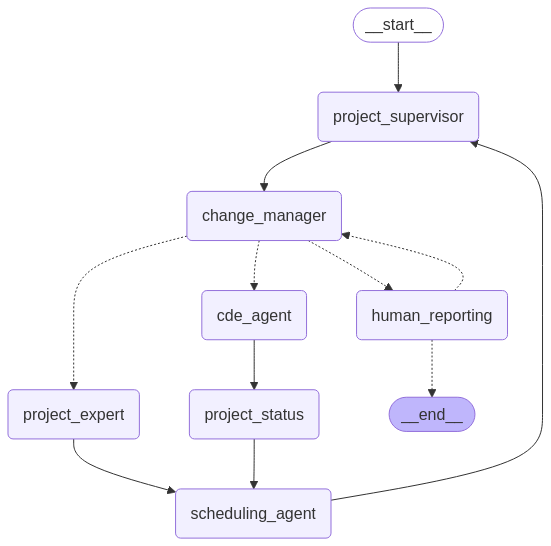

In [32]:
from IPython.display import Image, display

try:
    display(Image(workflow_graph.get_graph().draw_mermaid_png()))
except Exception as e:
        print(f"Error displaying graph: {e}")